# Transfer Learning with ResNet-18 and CIFAR-10

### In this notebook, we will translate a pre-trained ResNet-18 model on the CIFAR-10 dataset using PyTorch.

> Transfer learning means applying what a model has already learned to a new but similar problem.

> ResNet18 has been trained with dataset, ImageNet. It has 1000 image classes (e.g., cat, dog, plane, pizza...) with 224x224 input size.

*Goal:*
- Understand what transfer learning is
- Load and preprocess the CIFAR-10 dataset
- Modify a pre-trained ResNet-18 model for CIFAR-10 classification
- Train and evaluate the  in four cases (with your modifications)

## 1. Visualize CIFAR-10 and compare with ImagNet dataset.

### 1.1. Import Libraries

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary
import random
import pandas as pd

In [ ]:
#  If you are using Google Colab, run the following lines to install the required packages
!pip install torch torchvision
!pip install matplotlib
!pip install numpy
!pip install torchsummary
!pip install pandas

### 1.2. Visualize CIFAR-10 sample data

torch.Size([3, 32, 32])


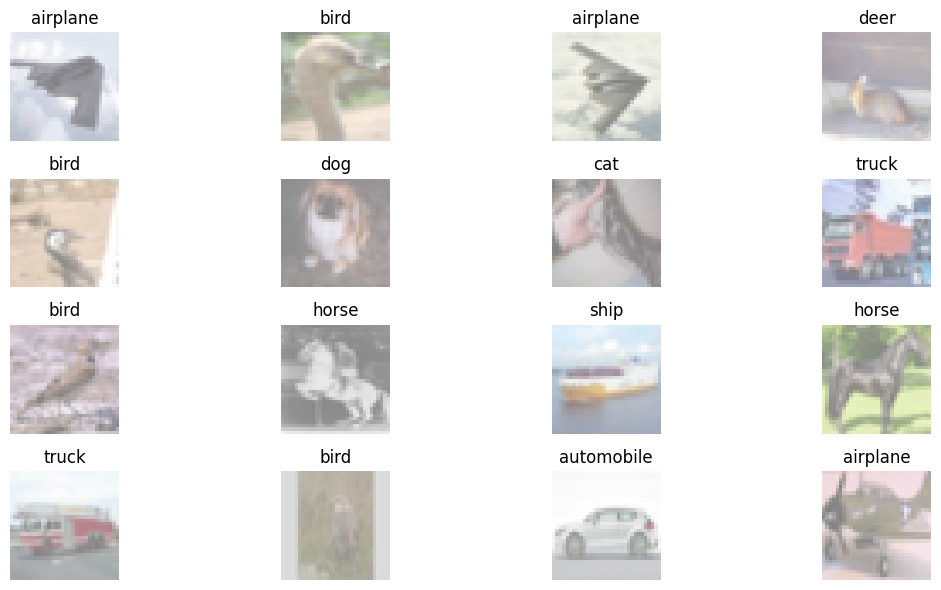

In [17]:
# Define CIFAR-10 transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
classes = cifar10.classes

# Random sample of 16 images
indices = random.sample(range(len(cifar10)), 16)
images, labels = zip(*[cifar10[i] for i in indices])

# print image shape and label
image, label = cifar10[0]
print(image.shape)  # Output: torch.Size([3, 32, 32])


# Plot
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(12, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


### What is the differences?
> - CIFAR-10:


> - ImageNet:

## 2. Transfer Learning Model

### 2-2. Data Preprocessing and Loading
Resize CIFAR-10 images to 224x224 because ResNet-18 expects that input size.

In [ ]:
transform = transforms.Compose([
    
    transforms. # ??? Resize CIFAR-10 images what ResNet-18 expects as input size.
    transforms. # ??? Randomly flip the images horizontally for data augmentation.,
    transforms. # ??? Convert images to tensor format,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

classes = trainset.classes

### 2-3. Load and Modify Pre-trained Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet-18 model
model = #???(pretrained=True)

# freeze all parameters (true or false)
for param in model.parameters():
    param.requires_grad = # ???

model.fc = nn.Linear(model.fc.in_features, #??? )  # Adjust for 10 CIFAR-10 classes
                     
'''You can make your own layer like below:
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)'''

model = model.to(device)

print("Model architecture:")
summary(model, input_size=(3,#???, ???)) Fill with your input size


Using device: cuda
Model architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128


### 2-4. Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=# ???)  # Set your learning rate, e.g., 0.001

### 2-5. Training Loop & Evaluation

In [ ]:
best_accuracy = 0.0
best_model_state = None
patience = 3
epochs_no_improve = 0
max_epochs = 50

train_losses = []
test_accuracies = []

start_time = time.time()

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch + 1}/{max_epochs}] - Avg Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping triggered at epoch {epoch + 1}")
            break

end_time = time.time()
print(f"\n Total training time: {end_time - start_time:.2f} seconds")

# Save best model
if best_model_state:
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), "best_model.pth")
    print(f" Loaded best model with accuracy: {best_accuracy:.2f}%")
    print(" Saved weights to 'best_model.pth'")

Epoch [1/50] - Avg Loss: 1.0635, Test Accuracy: 77.55%
Epoch [2/50] - Avg Loss: 0.7210, Test Accuracy: 78.54%
Epoch [3/50] - Avg Loss: 0.6737, Test Accuracy: 79.48%
Epoch [4/50] - Avg Loss: 0.6539, Test Accuracy: 80.09%
Epoch [5/50] - Avg Loss: 0.6335, Test Accuracy: 80.34%
Epoch [6/50] - Avg Loss: 0.6199, Test Accuracy: 80.67%
Epoch [7/50] - Avg Loss: 0.6147, Test Accuracy: 80.57%
Epoch [8/50] - Avg Loss: 0.5988, Test Accuracy: 80.87%
Epoch [9/50] - Avg Loss: 0.5903, Test Accuracy: 81.16%
Epoch [10/50] - Avg Loss: 0.5918, Test Accuracy: 80.87%
Epoch [11/50] - Avg Loss: 0.5800, Test Accuracy: 81.22%
Epoch [12/50] - Avg Loss: 0.5711, Test Accuracy: 81.04%
Epoch [13/50] - Avg Loss: 0.5674, Test Accuracy: 81.83%
Epoch [14/50] - Avg Loss: 0.5666, Test Accuracy: 81.43%
Epoch [15/50] - Avg Loss: 0.5592, Test Accuracy: 81.75%
Epoch [16/50] - Avg Loss: 0.5535, Test Accuracy: 81.74%

 Early stopping triggered at epoch 16

 Total training time: 545.08 seconds
 Loaded best model with accuracy: 81

### 2-6. Save results and visualization 

📄 Saved training log to 'training_log.csv'


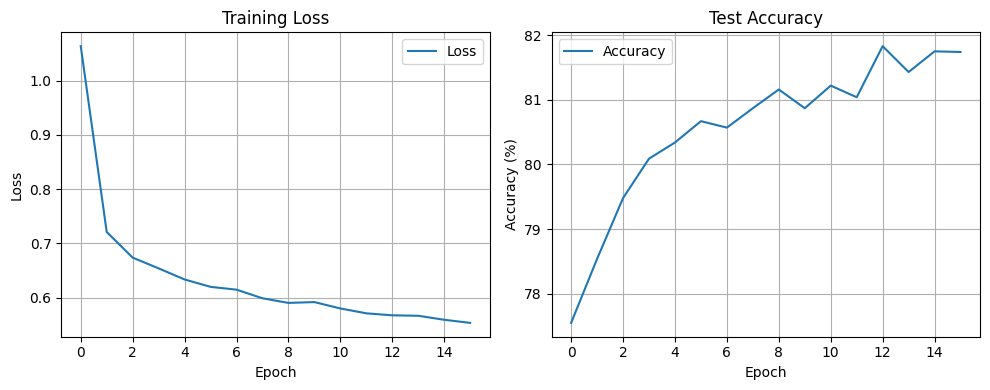

🖼️ Saved training plot to 'training_plot.png'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].


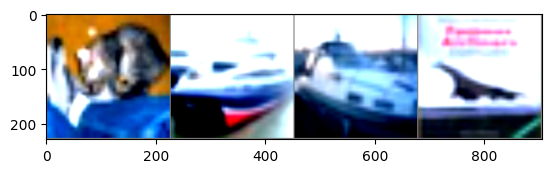

Predicted: ['cat', 'ship', 'ship', 'airplane']
Actual:    ['cat', 'ship', 'ship', 'airplane']
📝 Saved predictions to 'predictions.txt'


In [34]:
log_df = pd.DataFrame({
    'Epoch': list(range(1, len(train_losses)+1)),
    'Train_Loss': train_losses,
    'Test_Accuracy': test_accuracies
})
log_df.to_csv("training_log.csv", index=False)
print("📄 Saved training log to 'training_log.csv'")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()
print("🖼️ Saved training plot to 'training_plot.png'")

# --------------------------
# 6. 예측 결과 저장 및 시각화
# --------------------------
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

outputs = model(images[:4].to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted:", [classes[p] for p in predicted])
print("Actual:   ", [classes[l] for l in labels[:4]])

with open("predictions.txt", "w") as f:
    for i in range(4):
        f.write(f"Image {i+1} - Predicted: {classes[predicted[i]]}, Actual: {classes[labels[i]]}\n")
print("📝 Saved predictions to 'predictions.txt'")

## 3. Result

### Model 1
>1. Preprocess of Input images:

>2. Modification of the model:

>3. Optimizer and learning rate:

>3. Accuracy and loss (put the plots)

### Model 2
>1. Preprocess of Input images:

>2. Modification of the model:

>3. Optimizer and learning rate:

>3. Accuracy and loss (put the plots)

### Model 3
>1. Preprocess of Input images:

>2. Modification of the model:

>3. Optimizer and learning rate:

>3. Accuracy and loss (put the plots)

### Model 4
>1. Preprocess of Input images:

>2. Modification of the model:

>3. Optimizer and learning rate:

>3. Accuracy and loss (put the plots)

### What model do you think the best?
>